# SIGNALS PREPROCESSING
ECG signals often contain noise such as baseline wander (BW), powerline interference, EMG noise, and motion artifacts. To remove BW—typically caused by respiration and body movement: a two-stage median filter with window sizes of 200 ms and 600 ms was applied, following standard practices. Median filtering effectively removes low-frequency drift while preserving important signal features like R-peaks. After baseline correction, signals were normalized to a uniform amplitude range.

For segmentation, R-peaks were obtained from annotations. Each segment was extracted starting 20 samples before the P-wave, which was estimated to occur ~0.12 seconds (72 samples) before the R-peak. Thus, segments started at R_peak - 92 and contained 500 samples (~1.39 seconds), capturing a full cardiac cycle around each beat. These segments were labeled based on the annotation symbol at the corresponding R-peak, enabling multi-class arrhythmia classification.

In [41]:
#Baseline Wander removal
import numpy as np
from scipy.signal import medfilt

def remove_baseline_wander(signal, fs):
    # Convert window sizes to samples (ensure odd)
    window1 = int(0.2 * fs) | 1  # 200ms median filter
    window2 = int(0.6 * fs) | 1  # 600ms median filter
    
    # Remove QRS and estimate baseline
    qrs_removed = medfilt(signal, kernel_size=window1)
    baseline = medfilt(qrs_removed, kernel_size=window2)
    
    return signal - baseline

In [42]:
def normalize_signal(signal):
    return 2 * (signal - np.min(signal)) / (np.ptp(signal)) - 1

In [43]:
#Choose a random sample from the MIT-BIH Dataset
signal = wfdb.rdrecord('111', pn_dir='mitdb').p_signal[:, 0]

# Preprocess
cleaned = remove_baseline_wander(signal, fs=360)
normalized = normalize_signal(cleaned)

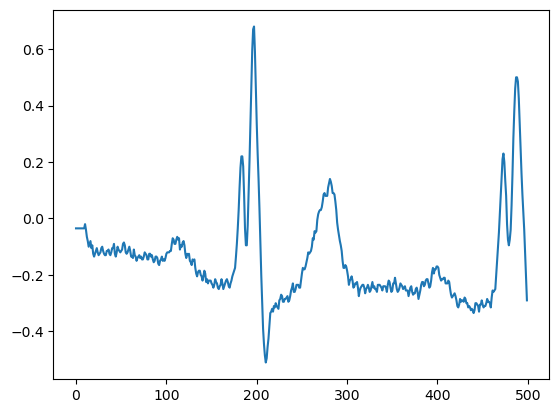

In [44]:
import matplotlib.pyplot as plt

plt.plot(signal[0:500], label="Original Signal")

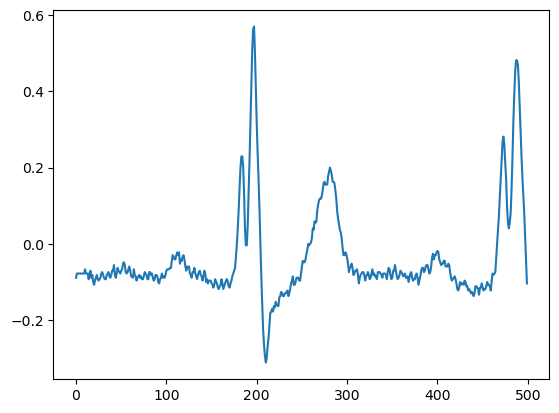

In [45]:
plt.plot(normalized[0:500], label="Processed Signal")

In [46]:
def extract_segments(signal, p_peaks, window_samples=500, pre_pad=20):
    segments = []
    for i in range(len(p_peaks)):
        start = p_peaks[i] - pre_pad  #Start 20 samples before P-wave
        end = start + window_samples
        if start > 0 and end < len(signal):  #Avoid out-of-bounds
            segment = signal[start:end]
            segments.append((start, end))
        else:
            segments.append((None, None))
    return segments

This function is used to create segments of 500 samples each from each data point in the dataset

## LOADING THE DATABASE

The MIT-BIH Arrhythmia Database is a widely used benchmark dataset for ECG classification. It contains 48 half-hour two-channel ECG recordings from 47 subjects, sampled at 360 Hz. Each record is manually annotated with R-peaks and beat-level rhythm labels by expert cardiologists. The dataset includes both normal and various arrhythmic heartbeats, making it suitable for multi-class arrhythmia detection tasks.

In [50]:
import wfdb
import numpy as np

valid_records = [
    100, 101, 102, 103, 104, 105, 106, 107, 108, 109,
    111, 112, 113, 114, 115, 116, 117, 118, 119, 121,
    122, 123, 124, 200, 201, 202, 203, 205, 207, 208,
    209, 210, 212, 213, 214, 215, 217, 219, 220, 221,
    222, 223, 228, 230, 231, 232, 233, 234
]

# Uncomment and run ONCE:
wfdb.dl_database('mitdb', dl_dir='mitdb')

Generating record list for: 100
Generating record list for: 101
Generating record list for: 102
Generating record list for: 103
Generating record list for: 104
Generating record list for: 105
Generating record list for: 106
Generating record list for: 107
Generating record list for: 108
Generating record list for: 109
Generating record list for: 111
Generating record list for: 112
Generating record list for: 113
Generating record list for: 114
Generating record list for: 115
Generating record list for: 116
Generating record list for: 117
Generating record list for: 118
Generating record list for: 119
Generating record list for: 121
Generating record list for: 122
Generating record list for: 123
Generating record list for: 124
Generating record list for: 200
Generating record list for: 201
Generating record list for: 202
Generating record list for: 203
Generating record list for: 205
Generating record list for: 207
Generating record list for: 208
Generating record list for: 209
Generati

In [53]:
def create_dataset():
    X, y = [], []
    for record_id in valid_records:
        try:
            record = wfdb.rdrecord(f'mitdb/{record_id}')
            annotation = wfdb.rdann(f'mitdb/{record_id}', 'atr')
            
            signal = record.p_signal[:, 0]
            cleaned = remove_baseline_wander(signal, fs=360)
            normalized = normalize_signal(cleaned)

            r_peaks = annotation.sample
            symbols = annotation.symbol
            p_peaks = [r - int(0.2 * 360) for r in r_peaks]
            segments = extract_segmens(signal, p_peaks)

            for k in range(len(segments)):
                start, end = segments[k]
                if start and end and symbols[k] not in ['~', '+']:
                    seg = normalized[start:end]
                    if len(seg) == 500:
                        X.append(seg)
                        y.append(symbols[k])
        except Exception as e:
            print(f"Skipping record {record_id}: {e}")
    return np.array(X), np.array(y)


In [54]:
X, y = create_dataset()
np.save('X_segments.npy', X)
np.save('y_labels.npy', y)

In [60]:
X.shape

(110658, 500)